## Schrodinger's Equation

In this module...

In [131]:
import numpy
from scipy.linalg import solve
from scipy.interpolate import spline
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [132]:
def generateMatrix(N, sigma):
    
    # Set Diagonalfrom discritization
    d = numpy.diag(numpy.ones(N-2)*(1+2j/sigma))
       
    # Set Upper Diagonal
    ud = numpy.diag(numpy.ones(N-3)*-1, 1)
    
    # Set Lower Diagonal
    ld = numpy.diag(numpy.ones(N-3)*-1, -1)
    
    A = d + ud + ld
    
    return A                   

In [133]:
#This is what we know

def genRHS(psi, sigma): 
    
    x = psi[1:-1]*((2j/sigma)+1) + psi[:-2] + psi[2:]
    
    #Dirichlet boundary conditions
    x[0] += psi[0]
    x[-1] += psi[0]
    
    return x

In [134]:
def CrankNicolson(psi, A, nt, sigma):
    
    for t in range(nt):
        psin = psi.copy()
        x = genRHS(psin, sigma)
        
        psi_inside = solve(A, x)
        psi[1:-1] = psi_inside
        
    return psi

In [135]:
L = 1
nx = 21 #21

h = 6.62607004e-34 #[m^2*kg/s]
hbar = h/(2*numpy.pi)
m = 6.6464764063e-27 #[kg] - mass of Helium ion
dx = L/(nx-1)


psii = numpy.zeros(nx, dtype = numpy.complex)
psii[0] = 1

sigma = 0.5 #0.5
dt = sigma*(dx**2)*m/hbar
nt = 10

A = generateMatrix(nx, sigma)

print(dt)

78781.69610432451


In [136]:
#print(A)

In [137]:
psi = CrankNicolson(psii.copy(), A, nt, sigma)

print(psi)

[ 1.00000000+0.j          0.10960598-1.05042239j -0.79679242-0.13775186j
  0.20605724+0.71590215j  1.10169886-0.43640978j -0.19337232-1.53361245j
 -1.53736352-0.30842116j -0.62802495+1.18155587j  0.66075056+0.75650277j
  0.46414791-0.29879663j -0.11330726-0.55169753j  0.07950534-0.15893489j
  0.30603336+0.45170703j -0.28298129+0.61074337j -0.75647896-0.16562401j
 -0.10020771-0.77312303j  0.54794803-0.2174064j   0.10306245+0.35915988j
 -0.39793900-0.06878749j  0.05489750-0.52538714j  0.00000000+0.j        ]


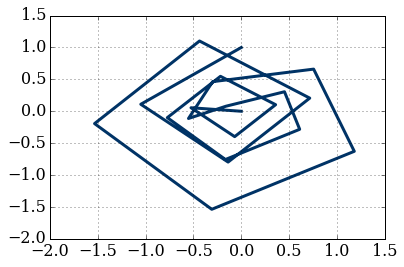

In [138]:
x = numpy.linspace(0,L,nx)

pyplot.plot(psi.imag, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)

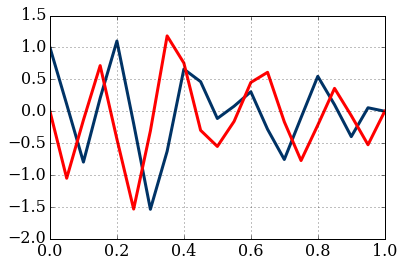

In [139]:
pyplot.plot(x, psi.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)
pyplot.plot(x, psi.imag, color='r', ls='-', lw=3);
pyplot.grid(True)


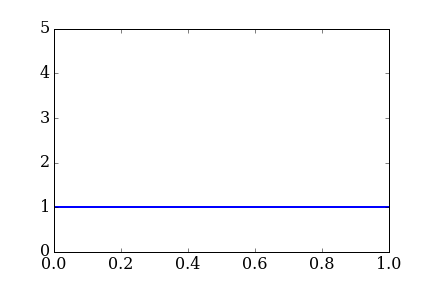
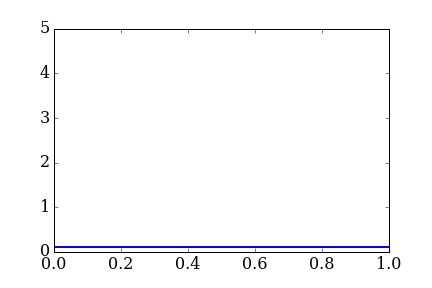
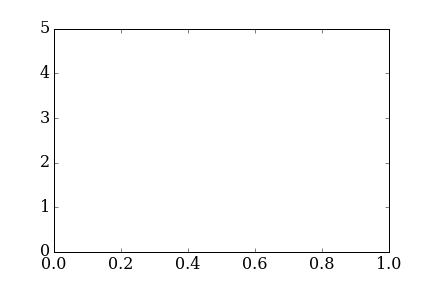
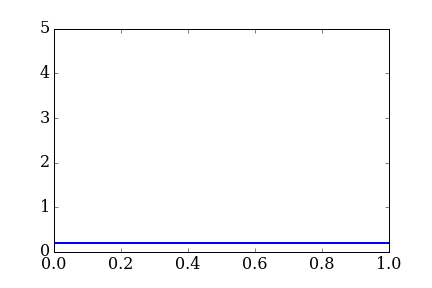
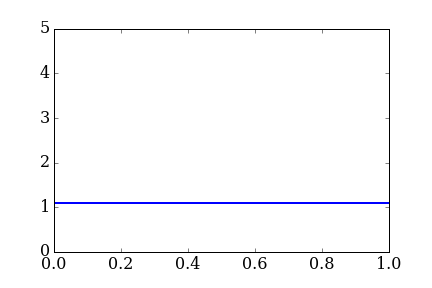
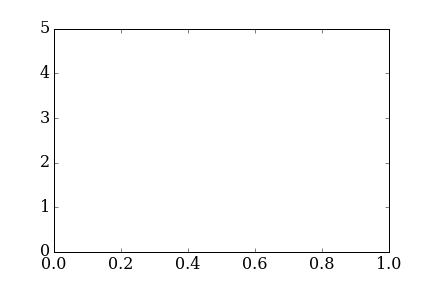
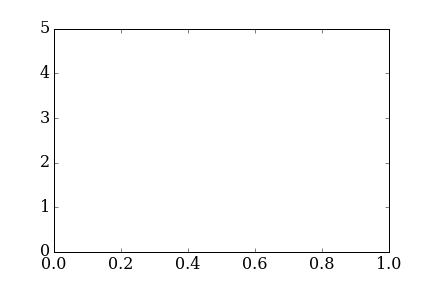
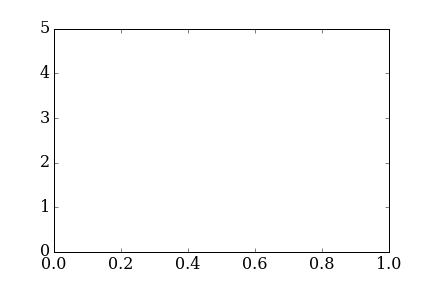
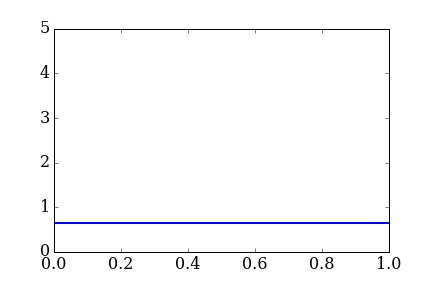
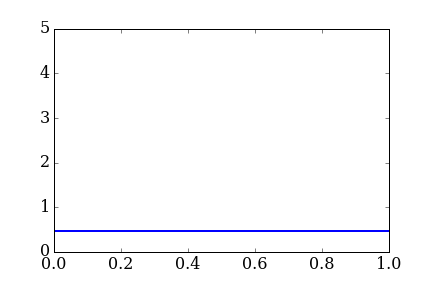
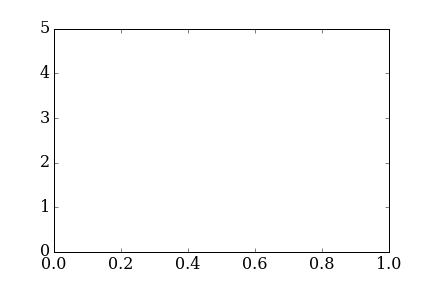
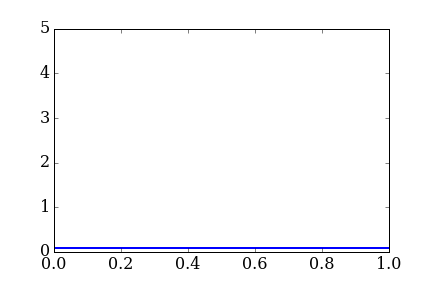
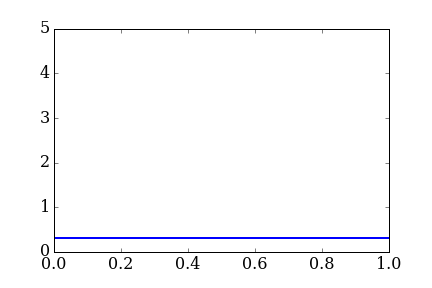
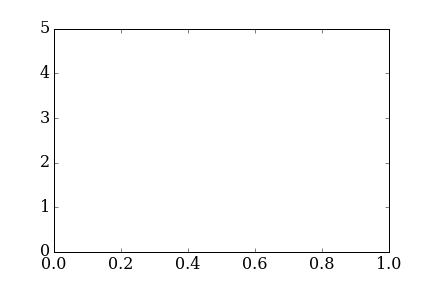
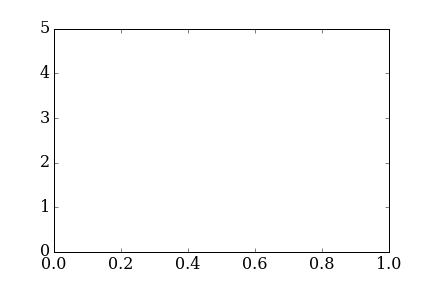
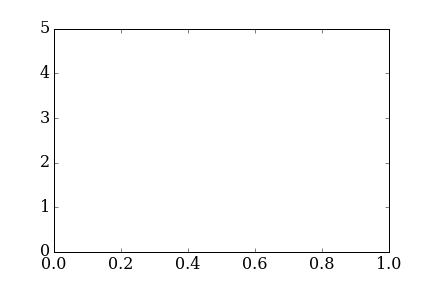
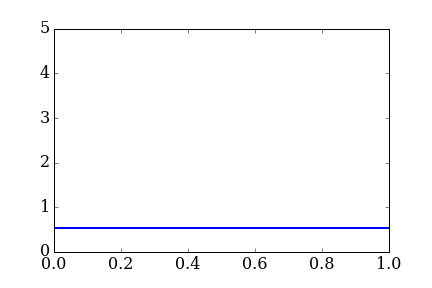
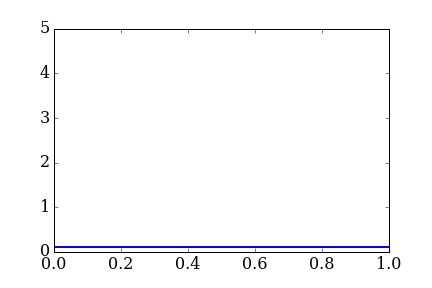
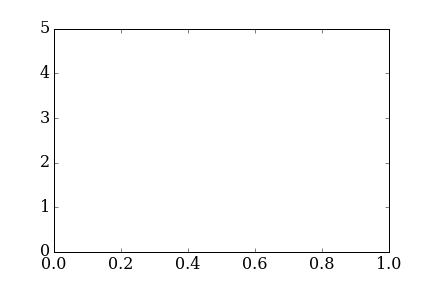
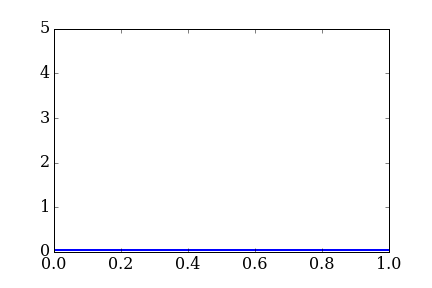
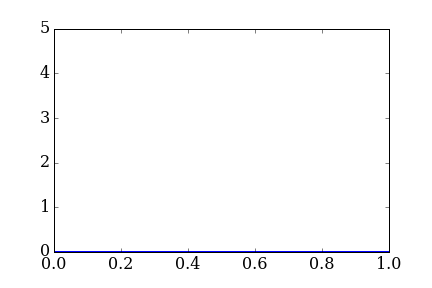

In [140]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

fig = pyplot.figure();
ax = pyplot.axes(xlim = (0,L), ylim = (0,5))
line, = ax.plot([],[],lw = 2)

def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames = psi.real, interval = 50)

display_animation(anim, default_mode = 'once')


In [141]:
psi_conj = numpy.conj(psi)
probfunc = psi_conj*psi

#print(psi_conj)
#print()
print(probfunc)
probfunc_real = probfunc.real
print(probfunc_real)

[ 1.00000000+0.j  1.11540066+0.j  0.65385374+0.j  0.55497548+0.j
  1.40419387+0.j  2.38935999+0.j  2.45861019+0.j  1.79048961+0.j
  1.00888775+0.j  0.30471271+0.j  0.31720870+0.j  0.03158140+0.j
  0.29769565+0.j  0.45308588+0.j  0.59969173+0.j  0.60776080+0.j
  0.34751258+0.j  0.13961769+0.j  0.16308717+0.j  0.27904538+0.j
  0.00000000+0.j]
[ 1.          1.11540066  0.65385374  0.55497548  1.40419387  2.38935999
  2.45861019  1.79048961  1.00888775  0.30471271  0.3172087   0.0315814
  0.29769565  0.45308588  0.59969173  0.6077608   0.34751258  0.13961769
  0.16308717  0.27904538  0.        ]


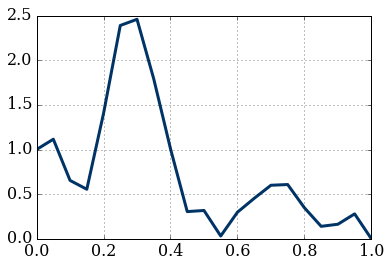

In [142]:
pyplot.plot(x, probfunc_real, color='#003366', ls='-', lw=3);
pyplot.grid(True)


In [143]:
def psi_analytical(x, t, n_max, h, m, L, hbar):
    
    psi = 1
    for n in range (1, n_max+1):
        
        E = ((n**2)*(h**2))/(8*m*(L**2))
        
        summation = numpy.sqrt(2/L)*numpy.sin(n*numpy.pi*x/L)*numpy.exp(-1j*E*t/hbar)
        psi+= summation
        
    return psi


In [148]:
psi_analytical = psi_analytical(x, dt*nt, 5, h, m, L, hbar)
print(psi_analytical)

[ 1.00000000 +0.00000000e+00j  2.67708271 -2.15193452e+00j
  3.99649554 -3.36885410e+00j  4.70737864 -3.17704924e+00j
  4.73514228 -1.78223734e+00j  4.19062710 +6.54460503e-02j
  3.31883932 +1.47781051e+00j  2.40907555 +1.88127715e+00j
  1.70070599 +1.27440208e+00j  1.31755472 +1.65289771e-01j
  1.25024713 -7.55403878e-01j  1.38641540 -1.00835362e+00j
  1.57135062 -5.63948427e-01j  1.67293356 +1.95759432e-01j
  1.62673663 +7.47705128e-01j  1.44786234 +7.56272695e-01j
  1.21019637 +2.61898408e-01j  1.00563402 -3.73750531e-01j
  0.90153755 -7.18388168e-01j  0.91310018 -5.51336781e-01j
  1.00000000 -4.87522292e-16j]


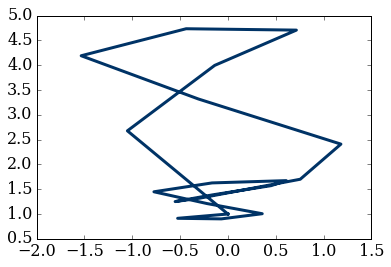

In [145]:
pyplot.plot(psi.imag, psi_analytical.real, color = '#003366', ls = '-', lw =3)

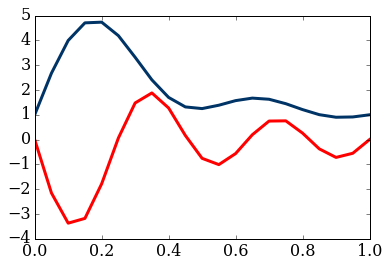

In [146]:
pyplot.plot(x, psi_analytical.real, color = '#003366', ls = '-', lw =3)
pyplot.plot(x, psi_analytical.imag, color = 'r', ls = '-', lw =3)

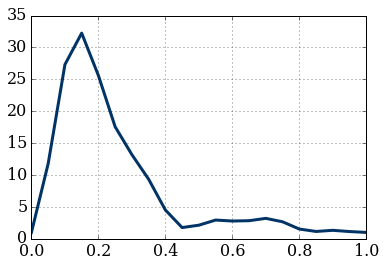

In [149]:
probfunc_analytical = numpy.conj(psi_analytical)*psi_analytical
pyplot.plot(x, probfunc_analytical.real, color='#003366', ls='-', lw=3);
pyplot.grid(True)